In [1]:
from pathlib import Path

import geopandas as gpd
import pandas as pd
import numpy as np
import xarray as xr
import rioxarray
import pdal
from dask.distributed import Client

from forest_structure_tools.metrics import forest_structure_metrics

In [2]:
data_dir = Path('../data/outputs')
sites_dir = data_dir / "sites"
sites_lidar_dir = sites_dir / "lidar"

plots_dir = data_dir / "plots"
plots_metrics_dir = plots_dir / "metrics"
plots_netcdf_output_dir = plots_metrics_dir / "x1-y1-z1" / "net_cdf"

plots_netcdf_output_dir.mkdir(parents=True, exist_ok=True)

In [3]:
plots = gpd.read_file(plots_dir / "plots.geojson")
plots = plots.set_index("id")
plots

,site,plot_number,site_plot_id,geometry
id,,,,
AGG_O_01_P1,AGG_O_01,1,AGG_O_01_P1,"POLYGON ((463042.83 5259846.736, 463025.797 52..."
AGG_O_01_P2,AGG_O_01,2,AGG_O_01_P2,"POLYGON ((463124.556 5259819.234, 463116.068 5..."
AGG_O_01_P3,AGG_O_01,3,AGG_O_01_P3,"POLYGON ((463201.174 5259815.806, 463200.551 5..."
AGG_O_01_P4,AGG_O_01,4,AGG_O_01_P4,"POLYGON ((463257.777 5259801.962, 463245.303 5..."
AGG_O_01_P5,AGG_O_01,5,AGG_O_01_P5,"POLYGON ((463303.022 5259789.552, 463289.794 5..."
...,...,...,...,...
ULY_Y_96_P1,ULY_Y_96,1,ULY_Y_96_P1,"POLYGON ((455348.476 5275834.517, 455348.154 5..."
ULY_Y_96_P2,ULY_Y_96,2,ULY_Y_96_P2,"POLYGON ((455296.576 5275837.224, 455299.223 5..."
ULY_Y_96_P3,ULY_Y_96,3,ULY_Y_96_P3,"POLYGON ((455252.092 5275834.16, 455248.849 52..."


In [ ]:
def read_points(input_path: str, polygon_wkt: str):
    pl = pdal.Reader(
        str(input_path), type="readers.copc", polygon=polygon_wkt
    ) | pdal.Filter(type="filters.range", limits="Classification[0:5]")
    count = pl.execute()
    print(f"Read in {count:,d} points")
    return pl.arrays[0]


def calculate_metrics(points: np.ndarray):
    metrics = forest_structure_metrics(
        points,
        xy_bin_size=1,
        z_bin_size=1,
    )

    # Add coordinate reference system and spatial dimensions
    metrics.rio.write_crs(7855, inplace=True)
    metrics.rio.set_spatial_dims(x_dim="x", y_dim="y", inplace=True)
    metrics.rio.write_coordinate_system(inplace=True)

    # Transpose for plotting and exporting to GeoTiffs

    metrics = metrics.transpose("y", "x", "z")

    return metrics


def calculate_metrics_for_plot(plot_id: str):
    plot = plots.loc[plot_id]
    polygon_wkt = plot.geometry.buffer(2).wkt
    input_path = sites_lidar_dir / f"{plot.site}.copc.laz"
    points = read_points(input_path, polygon_wkt)

    metrics = calculate_metrics(points)
    metrics["plot_id"] = plot_id

    metrics = metrics.rio.clip([plot.geometry])

    return metrics


def calculate_and_save_metrics_for_plot(plot_id: str):
    # Add import in here so Dask knows to import it
    import rioxarray
    
    metrics = calculate_metrics_for_plot(plot_id)
    metrics.to_netcdf(plots_netcdf_output_dir / f"{plot_id}.nc")
    metrics.close()

    grid_size = metrics["chm"].size
    vox_size = metrics["vox_inside"].size
    return (grid_size, vox_size)

In [5]:
test_metrics = calculate_metrics_for_plot("AGG_O_01_P1")
test_metrics

Read in 289,504 points


<xarray.Dataset> Size: 7MB
Dimensions:               (x: 67, y: 65, z: 18)
Coordinates:
  * x                     (x) float64 536B 4.63e+05 4.63e+05 ... 4.63e+05
  * y                     (y) float64 520B 5.26e+06 5.26e+06 ... 5.26e+06
    spatial_ref           int64 8B 0
  * z                     (z) float64 144B 0.0 1.0 2.0 3.0 ... 15.0 16.0 17.0
Data variables: (12/41)
    point_density         (y, x) float64 35kB nan nan nan nan ... nan nan nan
    pulse                 (y, x) float64 35kB nan nan nan nan ... nan nan nan
    chm                   (y, x) float64 35kB nan nan nan nan ... nan nan nan
    mean_height           (y, x) float64 35kB nan nan nan nan ... nan nan nan
    median_height         (y, x) float64 35kB nan nan nan nan ... nan nan nan
    q10_veg_height        (y, x) float64 35kB nan nan nan nan ... nan nan nan
    ...                    ...
    vci_w                 (y, x) float64 35kB nan nan nan nan ... nan nan nan
    shann_capture         (y, x) float64 35kB nan nan nan nan ... nan nan nan
    shann_capture_w       (y, x) float64 35kB nan nan nan nan ... nan nan nan
    norm_shann_capture    (y, x) float64 35kB nan nan nan nan ... nan nan nan
    norm_shann_capture_w  (y, x) float64 35kB nan nan nan nan ... nan nan nan
    plot_id               <U11 44B 'AGG_O_01_P1'
Attributes:
    xy_bin_size:  1
    z_bin_size:   1

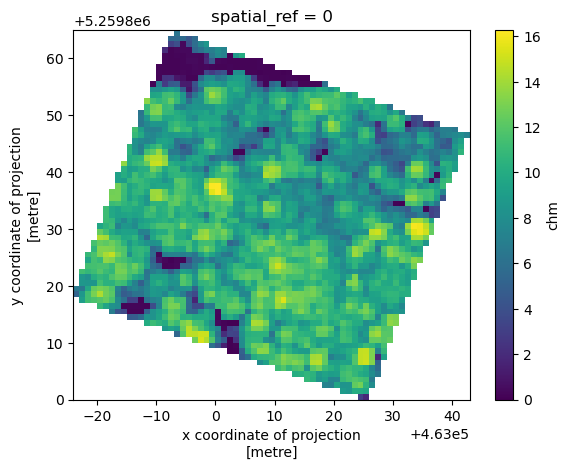

In [6]:
test_metrics['chm'].plot()

In [7]:
%%time

calculate_and_save_metrics_for_plot("AGG_O_01_P1")

Read in 289,504 points
CPU times: user 8.39 s, sys: 70.3 ms, total: 8.46 s
Wall time: 8.23 s


(4355, 78390)

In [8]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:49668,Workers: 0
Dashboard: http://127.0.0.1:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:49679,Total threads: 2
Dashboard: http://127.0.0.1:49681/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:49671,


In [9]:
%%time

plot_ids = plots.index.to_list()
futures = client.map(calculate_and_save_metrics_for_plot, plot_ids, key=plot_ids, retries=2)
results = client.gather(futures)

Read in 156,666 points
Read in 289,504 points
Read in 163,491 points
Read in 260,541 points
Read in 317,786 points
Read in 329,862 points
Read in 331,415 points
Read in 162,691 points
Read in 186,879 points
Read in 162,146 points
Read in 146,470 points
Read in 145,274 points
Read in 174,304 points
Read in 146,138 points
Read in 182,817 points
Read in 152,496 points
Read in 122,901 points
Read in 240,870 points


/Users/jgregory/Code/forest-structure-tools/.pixi/envs/default/lib/python3.13/site-packages/rasterio/features.py:392: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _rasterize(valid_shapes, out, transform, all_touched, merge_alg)


Read in 214,515 points
Read in 133,882 points
Read in 91,042 points
Read in 216,864 points
Read in 184,695 points
Read in 218,394 points
Read in 231,509 points
Read in 146,555 points
Read in 191,280 points
Read in 204,748 points
Read in 128,424 points
Read in 177,682 points
Read in 200,361 points
Read in 123,853 points
Read in 131,655 points
Read in 229,375 points
Read in 130,689 points
Read in 158,585 points
Read in 107,652 points
Read in 126,631 points
Read in 189,710 points
Read in 290,305 points
Read in 204,467 points
Read in 267,077 points
Read in 329,464 points
Read in 191,797 points
Read in 278,371 points
Read in 179,985 points
Read in 150,286 points
Read in 293,835 points
Read in 229,277 points
Read in 158,400 points
Read in 270,637 points
Read in 123,530 points
Read in 196,108 points
Read in 185,002 points
Read in 130,419 points
Read in 140,119 points
Read in 254,980 points
Read in 262,521 points
Read in 109,745 points
Read in 105,958 points
Read in 107,120 points
Read in 170,

/Users/jgregory/Code/forest-structure-tools/.pixi/envs/default/lib/python3.13/site-packages/rasterio/features.py:392: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _rasterize(valid_shapes, out, transform, all_touched, merge_alg)


Read in 100,672 points
Read in 360,945 points
Read in 137,216 points
Read in 220,630 points
Read in 108,059 points
Read in 124,218 points
Read in 305,103 points
Read in 140,663 points
Read in 108,244 points
Read in 124,467 points
Read in 242,769 points
Read in 374,320 points
Read in 315,140 points
Read in 301,500 points
Read in 381,564 points
Read in 315,198 points


/Users/jgregory/Code/forest-structure-tools/.pixi/envs/default/lib/python3.13/site-packages/rasterio/features.py:392: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _rasterize(valid_shapes, out, transform, all_touched, merge_alg)


Read in 203,715 points
Read in 410,454 points
Read in 95,979 points
Read in 370,336 points
Read in 145,154 points
Read in 131,313 points
Read in 291,500 points
Read in 158,834 points
Read in 167,354 points
Read in 115,125 points
Read in 191,707 points
Read in 214,591 points
Read in 299,547 points
Read in 169,547 points
Read in 179,971 points
Read in 194,972 points
Read in 106,195 points
Read in 125,779 points
Read in 81,825 points
Read in 184,702 points
Read in 232,946 points
Read in 222,395 points
Read in 147,770 points
Read in 194,196 points
Read in 211,385 points
Read in 184,970 points
Read in 139,437 points
Read in 226,110 points
Read in 241,810 points
Read in 144,798 points
Read in 185,025 points
Read in 190,159 points
Read in 170,735 points
Read in 163,040 points
Read in 241,153 points
Read in 264,077 points
Read in 318,156 points
Read in 115,997 points
Read in 362,786 points
Read in 308,091 points
Read in 164,560 points
Read in 161,295 points
Read in 234,775 points
Read in 121,2

In [ ]:
client.close()

In [13]:
total_grid = 0
total_voxel = 0
for result in results:
    grid, voxel = result
    total_grid += grid
    total_voxel += voxel

print(f"Total grid cells: {total_grid:,}")
print(f"Total voxel cells: {total_voxel:,}")


Total grid cells: 1,231,914
Total voxel cells: 43,776,960
